In [1]:
import pandas as pd
import numpy as np
from osgeo import gdal
from IPython.display import Image, display
import matplotlib.pyplot as plt

import arcgis
from arcgis.gis import GIS
from arcgis.raster.functions import remap, colormap,  contrast_brightness

In [2]:
gis = GIS(api_key="XXXXXXXX",
          referer="https")

<Item title:"Sentinel-2 Views" type:Imagery Layer owner:esri>
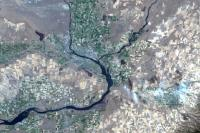

In [3]:
#Get the Sentinel-2 imagery layer
s2 = gis.content.get('fd61b9e0c69c4e14bebd50a9a968348c', )
sentinel = s2.layers[0]
s2


In [4]:
#Define Area of Interest, Donnie Creek (an area north of Fort St John), Prince George, BC, Canada
latitude_range = (57.3, 57.5)
longitude_range = (-122.2, -122)

aoi = {
    'xmin': longitude_range[0],
    'ymin': latitude_range[0],
    'xmax': longitude_range[1],
    'ymax': latitude_range[1],
    'spatialReference': {
        'wkid': 4326  # WGS 1984 coordinate system
    }
}

## Data Collection and Verification

The wildfire happened in May 2023 in AOI, so we will extract the sentinel-2 image before and after the wildfire. 

In [5]:
#Before wildfire
from datetime import datetime
pre_selected = sentinel.filter_by("(Category = 1)",
                             time=[datetime(2023, 3, 15), datetime(2023, 4, 15)],
                             geometry=arcgis.geometry.filters.intersects(aoi))

pre_df = pre_selected.query(out_fields="AcquisitionDate, GroupName, CloudCover, DayOfYear",
                   order_by_fields="AcquisitionDate", where= "cloudcover < 0.2").sdf

pre_df['AcquisitionDate'] = pd.to_datetime(pre_df['acquisitiondate'], unit='ms')
pre_df

/home/justin/anaconda3/envs/arcgis/lib/python3.9/site-packages/arcgis/features/geo/_io/serviceops.py:119: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[fld] = pd.to_datetime(


,objectid,acquisitiondate,groupname,cloudcover,dayofyear,SHAPE,AcquisitionDate
0,12517397,2023-03-19 19:28:41,20230319T192840_10VEJ_0,0.0039,78,"{""rings"": [[[-13490473.3493, 7794739.018600002...",2023-03-19 19:28:41
1,12490280,2023-03-24 19:28:45,20230324T192845_10VEJ_0,0.04,83,"{""rings"": [[[-13490473.3493, 7794739.018600002...",2023-03-24 19:28:45
2,12697119,2023-03-27 19:38:43,20230327T193842_10VEJ_0,0.0385,86,"{""rings"": [[[-13498129.012699999, 7771625.4459...",2023-03-27 19:38:43
3,12775118,2023-04-11 19:38:40,20230411T193839_10VEJ_0,0.1062,101,"{""rings"": [[[-13490521.7642, 7793859.985799998...",2023-04-11 19:38:40


In [6]:
#After wildfire
post_selected = sentinel.filter_by("(Category = 1)",
                             time=[datetime(2023, 5, 15), datetime(2023, 6, 7)],
                             geometry=arcgis.geometry.filters.intersects(aoi))

post_df = post_selected.query(out_fields="AcquisitionDate, GroupName, CloudCover, DayOfYear",
                   order_by_fields="AcquisitionDate", where= "cloudcover <0.2").sdf

post_df['AcquisitionDate'] = pd.to_datetime(post_df['acquisitiondate'], unit='ms')
post_df

/home/justin/anaconda3/envs/arcgis/lib/python3.9/site-packages/arcgis/features/geo/_io/serviceops.py:119: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[fld] = pd.to_datetime(


,objectid,acquisitiondate,groupname,cloudcover,dayofyear,SHAPE,AcquisitionDate
0,13360664,2023-05-16 19:38:44,20230516T193843_10VEJ_0,0.0415,136,"{""rings"": [[[-13505700.0732, 7750751.510499999...",2023-05-16 19:38:44
1,13151733,2023-05-18 19:28:45,20230518T192844_10VEJ_0,0.0782,138,"{""rings"": [[[-13490473.3493, 7794739.018600002...",2023-05-18 19:28:45
2,13247969,2023-05-26 19:38:44,20230526T193844_10VEJ_0,0.1974,146,"{""rings"": [[[-13490561.3779, 7792369.240800001...",2023-05-26 19:38:44


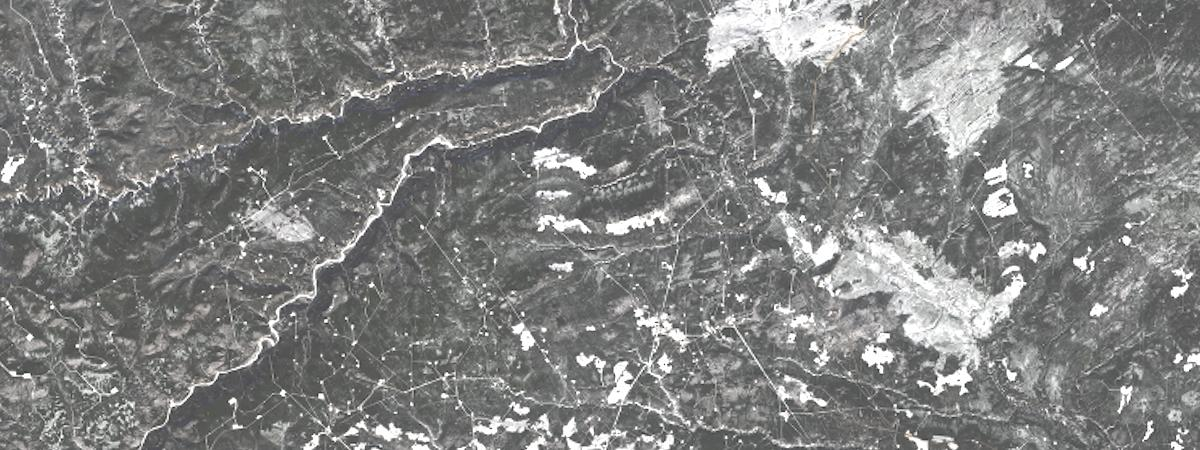

In [7]:
prefire = sentinel.filter_by('OBJECTID=12517397')
prefire.extent = aoi
prefire_map = contrast_brightness(prefire, contrast_offset=-5, brightness_offset=20)
prefire_map

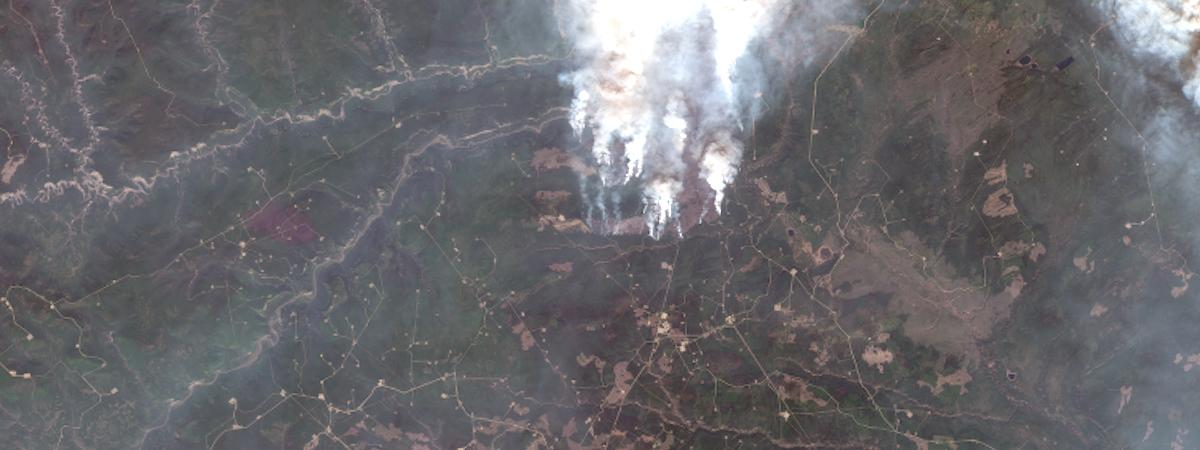

In [8]:
midfire = sentinel.filter_by('OBJECTID=13151733')
midfire.extent = aoi
midfire_map = contrast_brightness(midfire, contrast_offset=-5, brightness_offset=20)
midfire_map

We can clearly sees the fire in this RGB image on 18 May 2023.

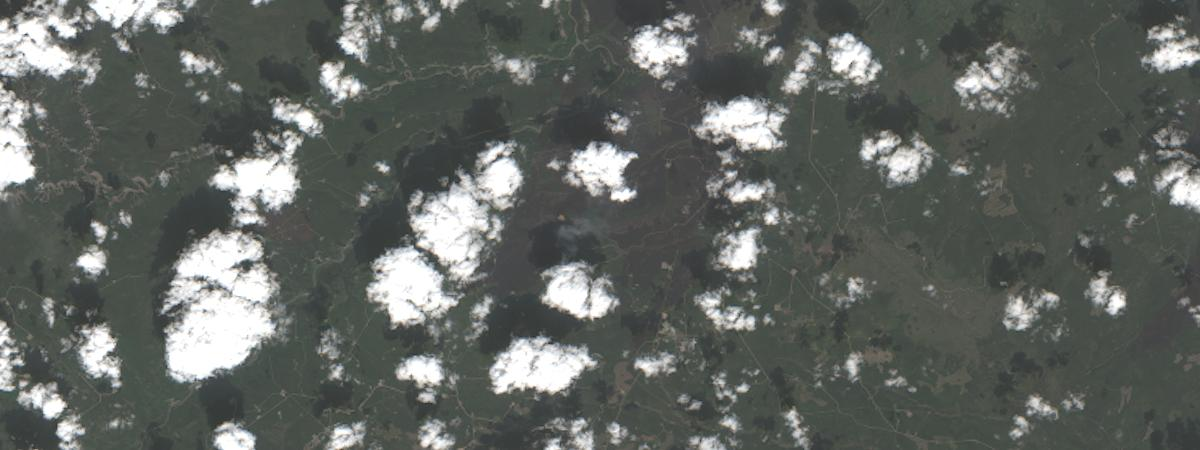

In [9]:
postfire = sentinel.filter_by('OBJECTID=13247969')
postfire.extent = aoi
postfire_map = contrast_brightness(postfire, contrast_offset=-5, brightness_offset=20)
postfire_map

## Quantitative Assessment with Normalized Burn Ratio (NBR)

The Normalized Burn Ratio (NBR) is an index designed to highlight burnt areas in large fire zones. The formula is similar to NDVI, except that the formula combines the use of both near infrared (NIR) and shortwave infrared (SWIR) wavelengths.

![Comparison of the spectral response of healthy vegetation and burned areas](https://un-spider.org/sites/default/files/Spectral_responses.jpg)

And the calculation of NBR has the formula below:

![Calculation of NBR](https://un-spider.org/sites/default/files/NBR_formula.jpg)

In short, a high NBR value indicates healthy vegetation while a low value indicates bare ground and recently burnt areas. You may refer to https://un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/in-detail/normalized-burn-ratio for more details.

In [10]:
#We will get the NBR layer directly from Arcgis domain
s2_NBR = gis.content.get('5cbafcf777e845129771e601701aaae7')
sentinel_NBR = s2_NBR.layers[0]
sentinel_NBR.raster_info


{'extent': {'xmin': -20037208.6216,
  'ymin': -10100722.918799996,
  'xmax': 20037211.3784,
  'ymax': 12121837.081200004,
  'spatialReference': {'wkid': 102100, 'latestWkid': 3857}},
 'bandCount': 1,
 'pixelType': 'F32',
 'pixelSizeX': 10,
 'pixelSizeY': 10,
 'compressionType': 'None',
 'blockHeight': 256,
 'blockWidth': 2048}

Now, have a look on the NBR image of the same period.

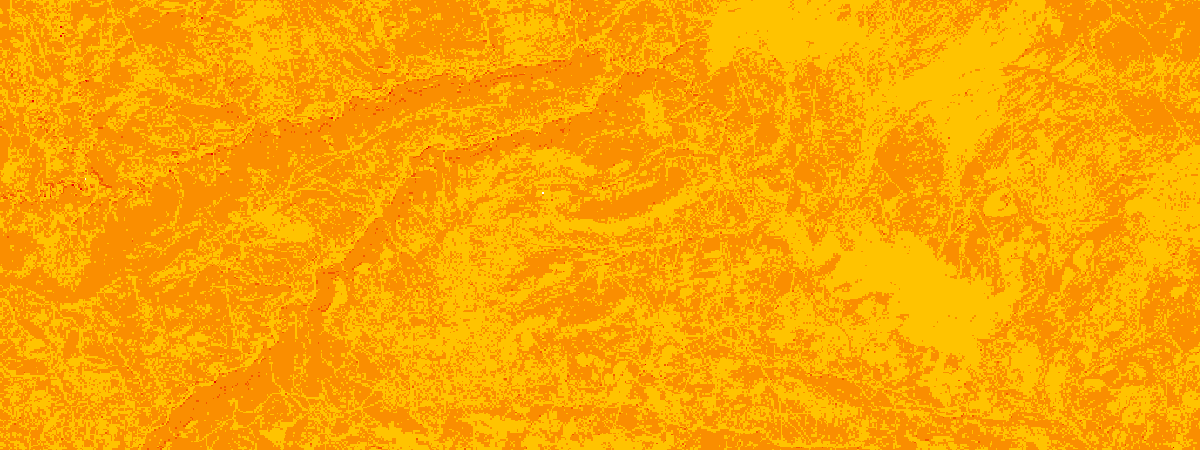

In [11]:
nbr_prefire = sentinel_NBR.filter_by('OBJECTID= 12517397')
pre_areas = colormap(remap(nbr_prefire, 
                             input_ranges=[-0.8, -0.3,  
                                           -0.3, 0.1,
                                           0.1, 0.4, 
                                           0.4, 1.00],
                             output_values=[1, 2, 3, 4],                    
                             no_data_ranges=[-1, -0.8]), 
                       colormap=[[4, 0xFF, 0xC3, 0], [3, 0xFA, 0x8E, 0], [2, 0xF2, 0x55, 0], [1, 0xE6, 0, 0]])
pre_areas.extent = aoi
pre_areas

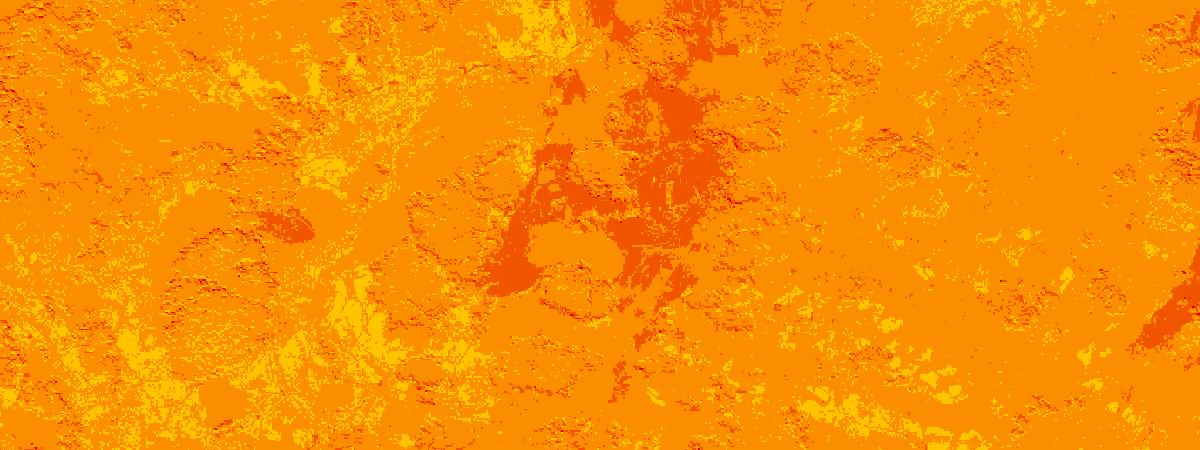

In [12]:
nbr_postfire = sentinel_NBR.filter_by('OBJECTID=13247969')
nbr_postfire.extent = aoi
post_areas = colormap(remap(nbr_postfire, 
                             input_ranges=[-0.8, -0.3,  
                                           -0.3, 0,
                                           0, 0.3, 
                                           0.3, 1.00],
                             output_values=[1, 2, 3, 4],                    
                             no_data_ranges=[-1, -0.8]), 
                       colormap=[[4, 0xFF, 0xC3, 0], [3, 0xFA, 0x8E, 0], [2, 0xF2, 0x55, 0], [1, 0xE6, 0, 0]])
post_areas.extent = aoi
post_areas

The postfire image has a more negative value, indicating area was burnt. To quantify the severity, we will calculate the difference in NBR (dNBR) between before and after wildfile. </br>
First we will output the two images as tiff, and we will use GDAL to calculate the dNBR. 

In [13]:
nbr_prefire.export_image(size=[1200, 450],
                            bbox=aoi,
                           export_format="tiff",
                           f="image",
                           save_folder=r"/home/justin/wildfire",
                           save_file="nbr_prefire.tif")

'/home/justin/wildfire/nbr_prefire.tif'

In [14]:
nbr_postfire.export_image(size=[1200, 450],
                            bbox=aoi,
                           export_format="tiff",
                           f="image",
                           save_folder=r"/home/justin/wildfire",
                           save_file="nbr_postfire.tif")

'/home/justin/wildfire/nbr_postfire.tif'

The nbr difference is calculated with gdal in bash, with </br>
*gdal_calc.py -A nbr_prefire.tif -B nbr_postfire.tif --outfile=nbr_diff.tif --calc="A-B" --overwrite --co "CRS=EPSG:3857"*

In [15]:
!gdal_calc.py -A nbr_prefire.tif -B nbr_postfire.tif --outfile=nbr_diff.tif --calc="A-B" --overwrite --co "CRS=EPSG:3857"*

Warning 6: driver GTiff does not support creation option CRS
0.. 2.. 5.. 7.. 10.. 12.. 15.. 17.. 20.. 22.. 25.. 27.. 30.. 32.. 35.. 37.. 40.. 42.. 45.. 47.. 50.. 52.. 55.. 57.. 60.. 62.. 65.. 67.. 70.. 72.. 75.. 77.. 80.. 82.. 85.. 87.. 90.. 92.. 95.. 97.. 100 - Done


In [16]:
#Open the calculated NBR difference raster (nbr_diff.tif) using GDAL
dataset = gdal.Open('nbr_diff.tif')
if dataset is None:
    print("Failed to open file.")
    exit()

# Read the raster band
band = dataset.GetRasterBand(1)
nbr_array = band.ReadAsArray()

In [17]:
#Checking the size of the array
nbr_array.shape

(450, 1200)

We will then have a look on the change in NBR (dNBR).

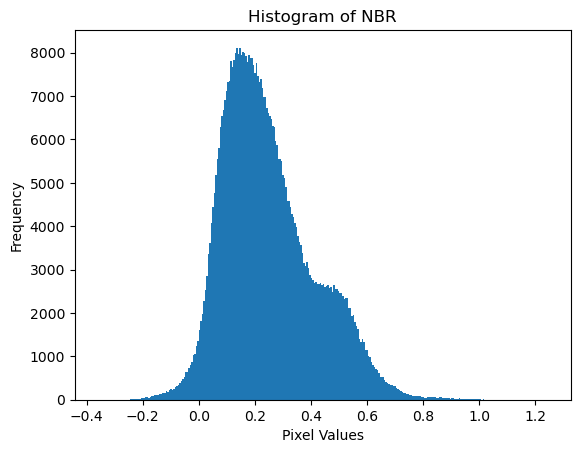

In [18]:
nbr_flat = nbr_array.flatten()
plt.hist(nbr_flat, bins='auto')
plt.xlabel('Pixel Values')
plt.ylabel('Frequency')
plt.title('Histogram of NBR')
plt.show()

It is noted that the change in NBR (dNBR) is mostly positive, indicating area burnt. We will then visualize the area burnt with matplotlib.

In [19]:
colormap = {
    1: [166, 21, 208], 
    2: [244, 104, 46], 
    3: [245, 177, 78], 
    4: [245, 251, 63],
    5: [31, 226, 79] 
}

remap_ranges = [
    [0.66, 1.3],
    [0.44, 0.66],
    [0.27, 0.44], 
    [0.1, 0.27],
    [-0.4, 0.1]   
]

output_values = [1, 2, 3, 4, 5]


In [20]:
# Remap values
remapped = np.zeros_like(nbr_array)
for i in range(len(remap_ranges)):
    mask = np.logical_and(nbr_array >= remap_ranges[i][0], nbr_array < remap_ranges[i][1])
    remapped[mask] = output_values[i]

# Apply colormap
rgb = np.zeros((*remapped.shape, 3), dtype=np.uint8)
for i, color in colormap.items():
    mask = remapped == i
    rgb[mask] = color

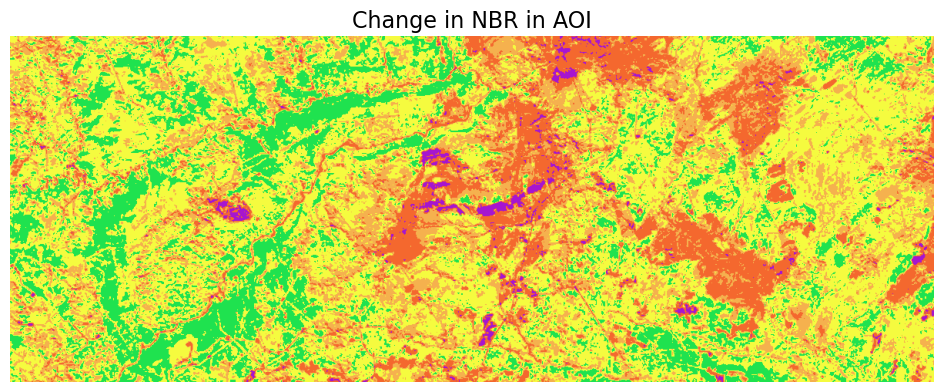

In [26]:
# Display the result with customized settings
plt.figure(figsize=(12, 4.5)) 
plt.imshow(rgb)
plt.axis('off')
plt.title('Change in NBR in AOI', fontsize=16)
plt.show()

The change in NBR (dNBR) is defined as below, according to UN-SPIDER Knowledge Portal:
![dNBR](https://un-spider.org/sites/default/files/table+legend.PNG)

The greenish area indicates no decrease or minimal decrease in NBR (dNBR <0.1), meaning no significant change in vegetation. Whereas the area in yellow, oranage, purple indicates the extent of burnt area.

## Area Burnt

With the help of np.array, we can easily check the % of area burnt in our AOI.

In [22]:
#Total area (no. of pixels)
nbr_flat.shape[0]

540000

In [23]:
burnt_percent = np.count_nonzero(nbr_flat >= 0.1)/nbr_flat.shape[0]
print('Percent of area burnt: {:.2f}%'.format(burnt_percent*100))

Percent of area burnt: 82.25%


In [24]:
midhigh_percent = np.count_nonzero(nbr_flat >= 0.44)/nbr_flat.shape[0]
print('Percent of area burnt with Mid-high to high severity: {:.2f}%'.format(midhigh_percent*100))

Percent of area burnt with Mid-high to high severity: 14.75%


Since each pixel has a size of 10x10m, we can also calculate the affected area easily.

In [25]:
area_affected = np.count_nonzero(nbr_flat >= 0.1)*10*10*1e-6
print(f'Burnt area in AOI in km^2: {area_affected :.2f}')

Burnt area in AOI in km^2: 44.41


In our AOI, more than 80% of the area (44.4km^2) were exposed to wildfire, and near 15% of area are severily burnt.

## Conclusion

In this study, we have used ESRI Arcgis Python API to analyze a wildfire event near Fort St John, in May 2023. By calculating the change in Normalized Burn Ratio in our AOI, we are able to visualize the severity of wildfire extent, as well as determining the area affected.